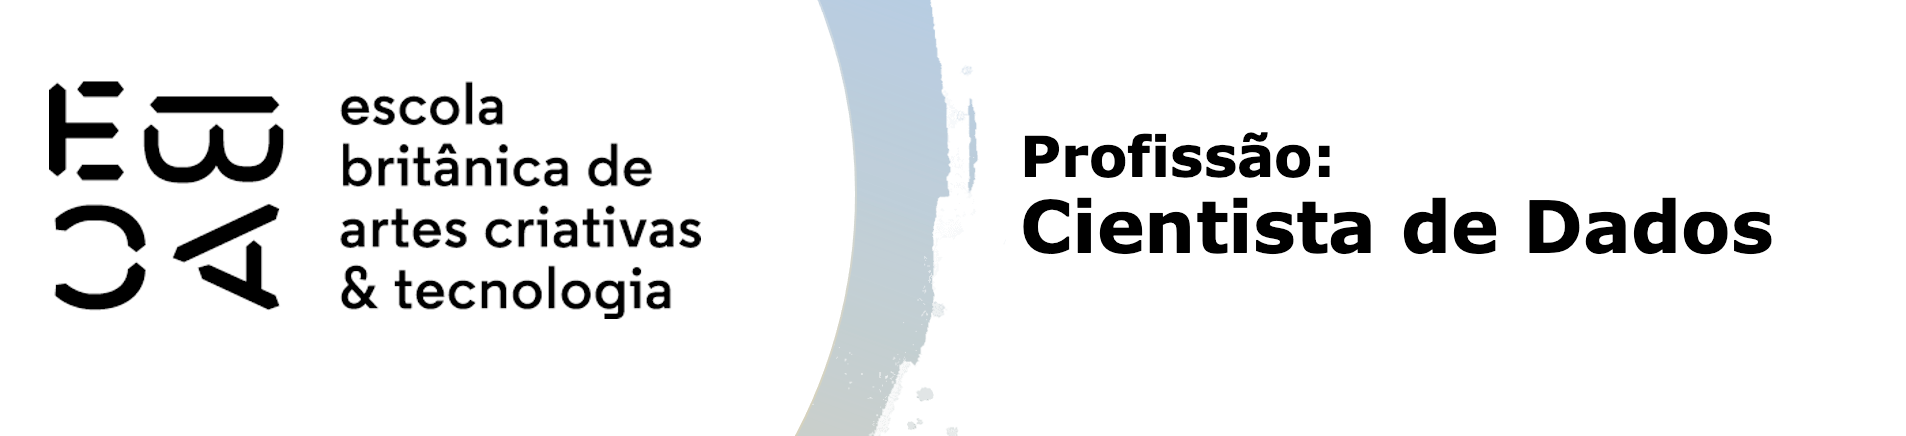

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
#Importação das Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from script import analise
from script import IV
from script import biv_discreta
from script import biv_continua

%reload_ext watermark
%watermark -iv -v

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.21.0

plotly     : 5.20.0
matplotlib : 3.8.3
pandas     : 2.2.0
sklearn    : 1.4.1.post1
seaborn    : 0.13.2
statsmodels: 0.14.1
numpy      : 1.26.4



In [2]:
# Dicionário dos Meses.

meses = {1:  'Jan',
         2:  'Fev',
         3:  'Mar',
         4:  'Abr',
         5:  'Mai',
         6:  'Jun',
         7:  'Jul',
         8:  'Ago',
         9:  'Set',
         10: 'Out',
         11: 'Nov',
         12: 'Dez'}

In [3]:
#Lendo CSV.

credit_scoring = pd.read_feather('./Dados/credit_scoring.ftr')
credit_scoring

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Tratando os Dados

df = credit_scoring.copy()
df.drop(columns='index', inplace=True)
df.set_index(keys='data_ref', inplace=True)
df.fillna({'tempo_emprego': -1}, inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [5]:
#Definindo o DataFrame de Treino e de Test(Validação).

df_train = df.loc[~df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]
df_test = df.loc[df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
# Número de linhas para cada mês tanto do Treino quanto do Teste.

print(f'\033[1;92mDF_TRAIN:\033[0;1m\n{df_train.index.value_counts()}')
print('-'*25)
print(f'\033[1;94mDF_TEST:\033[0;1m{df_test.index.value_counts()}')

DF_TRAIN:
data_ref
Jan_2015    50000
Fev_2015    50000
Mar_2015    50000
Abr_2015    50000
Mai_2015    50000
Jun_2015    50000
Jul_2015    50000
Ago_2015    50000
Set_2015    50000
Out_2015    50000
Nov_2015    50000
Dez_2015    50000
Name: count, dtype: int64
-------------------------
DF_TEST:data_ref
Jan_2016    50000
Fev_2016    50000
Mar_2016    50000
Name: count, dtype: int64


In [7]:
#Analise do DataFrame

analise_df = analise(df, y='mau')
analise_df

,dtype,contagem,missing,nunique,papel
sexo,object,750000,0,2,covariavel
posse_de_veiculo,object,750000,0,2,covariavel
posse_de_imovel,object,750000,0,2,covariavel
qtd_filhos,int64,750000,0,8,covariavel
tipo_renda,object,750000,0,5,covariavel
educacao,object,750000,0,5,covariavel
estado_civil,object,750000,0,5,covariavel
tipo_residencia,object,750000,0,6,covariavel
idade,int64,750000,0,47,covariavel
tempo_emprego,float64,750000,0,3005,covariavel


CONTAGEM "mau":
mau
False    691357
True      58643
Name: count, dtype: int64
--------------------------------
PERCENTUAL "mau":
mau
False    92.18 %
True      7.82 %
Name: proportion, dtype: object


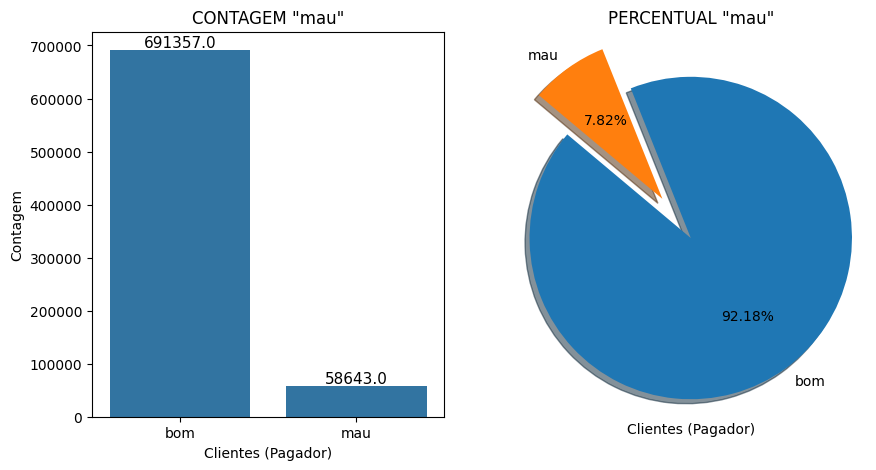

In [8]:
#Analisando os "mau" Pagadores

print(f'\033[1;92mCONTAGEM "mau":\n\033[0m{df.mau.value_counts()}')
print('-'*32)
print(f'\033[1;94mPERCENTUAL "mau":\n\033[0m{(df.mau.value_counts(normalize=True)*100).round(2).astype(str) + ' %'}')

fig, axes = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.barplot(df.mau.map({True: 'mau', False: 'bom'}).value_counts(), ax=axes[0])
ax1.set_title('CONTAGEM "mau"')
ax1.set_xlabel('Clientes (Pagador)')
ax1.set_ylabel('Contagem')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

ax2 = plt.pie(df.mau.map({True: 'mau', False: 'bom'}).value_counts(normalize=True), explode=(0, 0.3), labels=['bom', 'mau'], autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('PERCENTUAL "mau"')
plt.xlabel('Clientes (Pagador)')
plt.axis('equal')

plt.show()

In [9]:
# Categorizando as variáveis maiores.

df_cut = df.copy()
df_cut['idade'] = pd.qcut(df['idade'], 9, precision=0, duplicates='drop')
df_cut['renda'] = pd.qcut(df['renda'], 9, precision=0, duplicates='drop')
df_cut['tempo_emprego'] = pd.qcut(df['tempo_emprego'], 9, precision=0, duplicates='drop')
df_cut

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,"(41.0, 45.0]","(6.0, 7.0]",1.0,"(1874.0, 3123.0]",False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,"(33.0, 37.0]","(4.0, 6.0]",2.0,"(3123.0, 4634.0]",False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,"(29.0, 33.0]","(-2.0, 1.0]",4.0,"(107.0, 1874.0]",False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,"(49.0, 54.0]","(10.0, 15.0]",2.0,"(13433.0, 20621.0]",False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,"(29.0, 33.0]","(7.0, 10.0]",1.0,"(1874.0, 3123.0]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mar_2016,M,N,S,0,Empresário,Superior completo,Casado,Casa,"(45.0, 49.0]","(2.0, 4.0]",2.0,"(1874.0, 3123.0]",False
Mar_2016,F,N,S,0,Pensionista,Médio,Solteiro,Casa,"(59.0, 68.0]","(-2.0, 1.0]",1.0,"(107.0, 1874.0]",False
Mar_2016,M,S,N,2,Assalariado,Médio,Casado,Casa,"(41.0, 45.0]","(10.0, 15.0]",4.0,"(107.0, 1874.0]",True


In [10]:
# Descriação de cada variavel.

print(f'{'-'*32}\n{df.index.value_counts()}')
for i in df.columns:
    if df[i].dtype == object:
        print(f'{'-'*32}\n{i}\n\n{df[i].value_counts()}')
    else:
        print(f'{'-'*32}\n{i}\n\n{df[i].describe().round(2)}')

--------------------------------
data_ref
Jan_2015    50000
Fev_2015    50000
Mar_2015    50000
Abr_2015    50000
Mai_2015    50000
Jun_2015    50000
Jul_2015    50000
Ago_2015    50000
Set_2015    50000
Out_2015    50000
Nov_2015    50000
Dez_2015    50000
Jan_2016    50000
Fev_2016    50000
Mar_2016    50000
Name: count, dtype: int64
--------------------------------
sexo

sexo
F    504580
M    245420
Name: count, dtype: int64
--------------------------------
posse_de_veiculo

posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64
--------------------------------
posse_de_imovel

posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64
--------------------------------
qtd_filhos

count    750000.00
mean          0.43
std           0.74
min           0.00
25%           0.00
50%           0.00
75%           1.00
max          14.00
Name: qtd_filhos, dtype: float64
--------------------------------
tipo_renda

tipo_renda
Assalariado         385740
Empresário          1

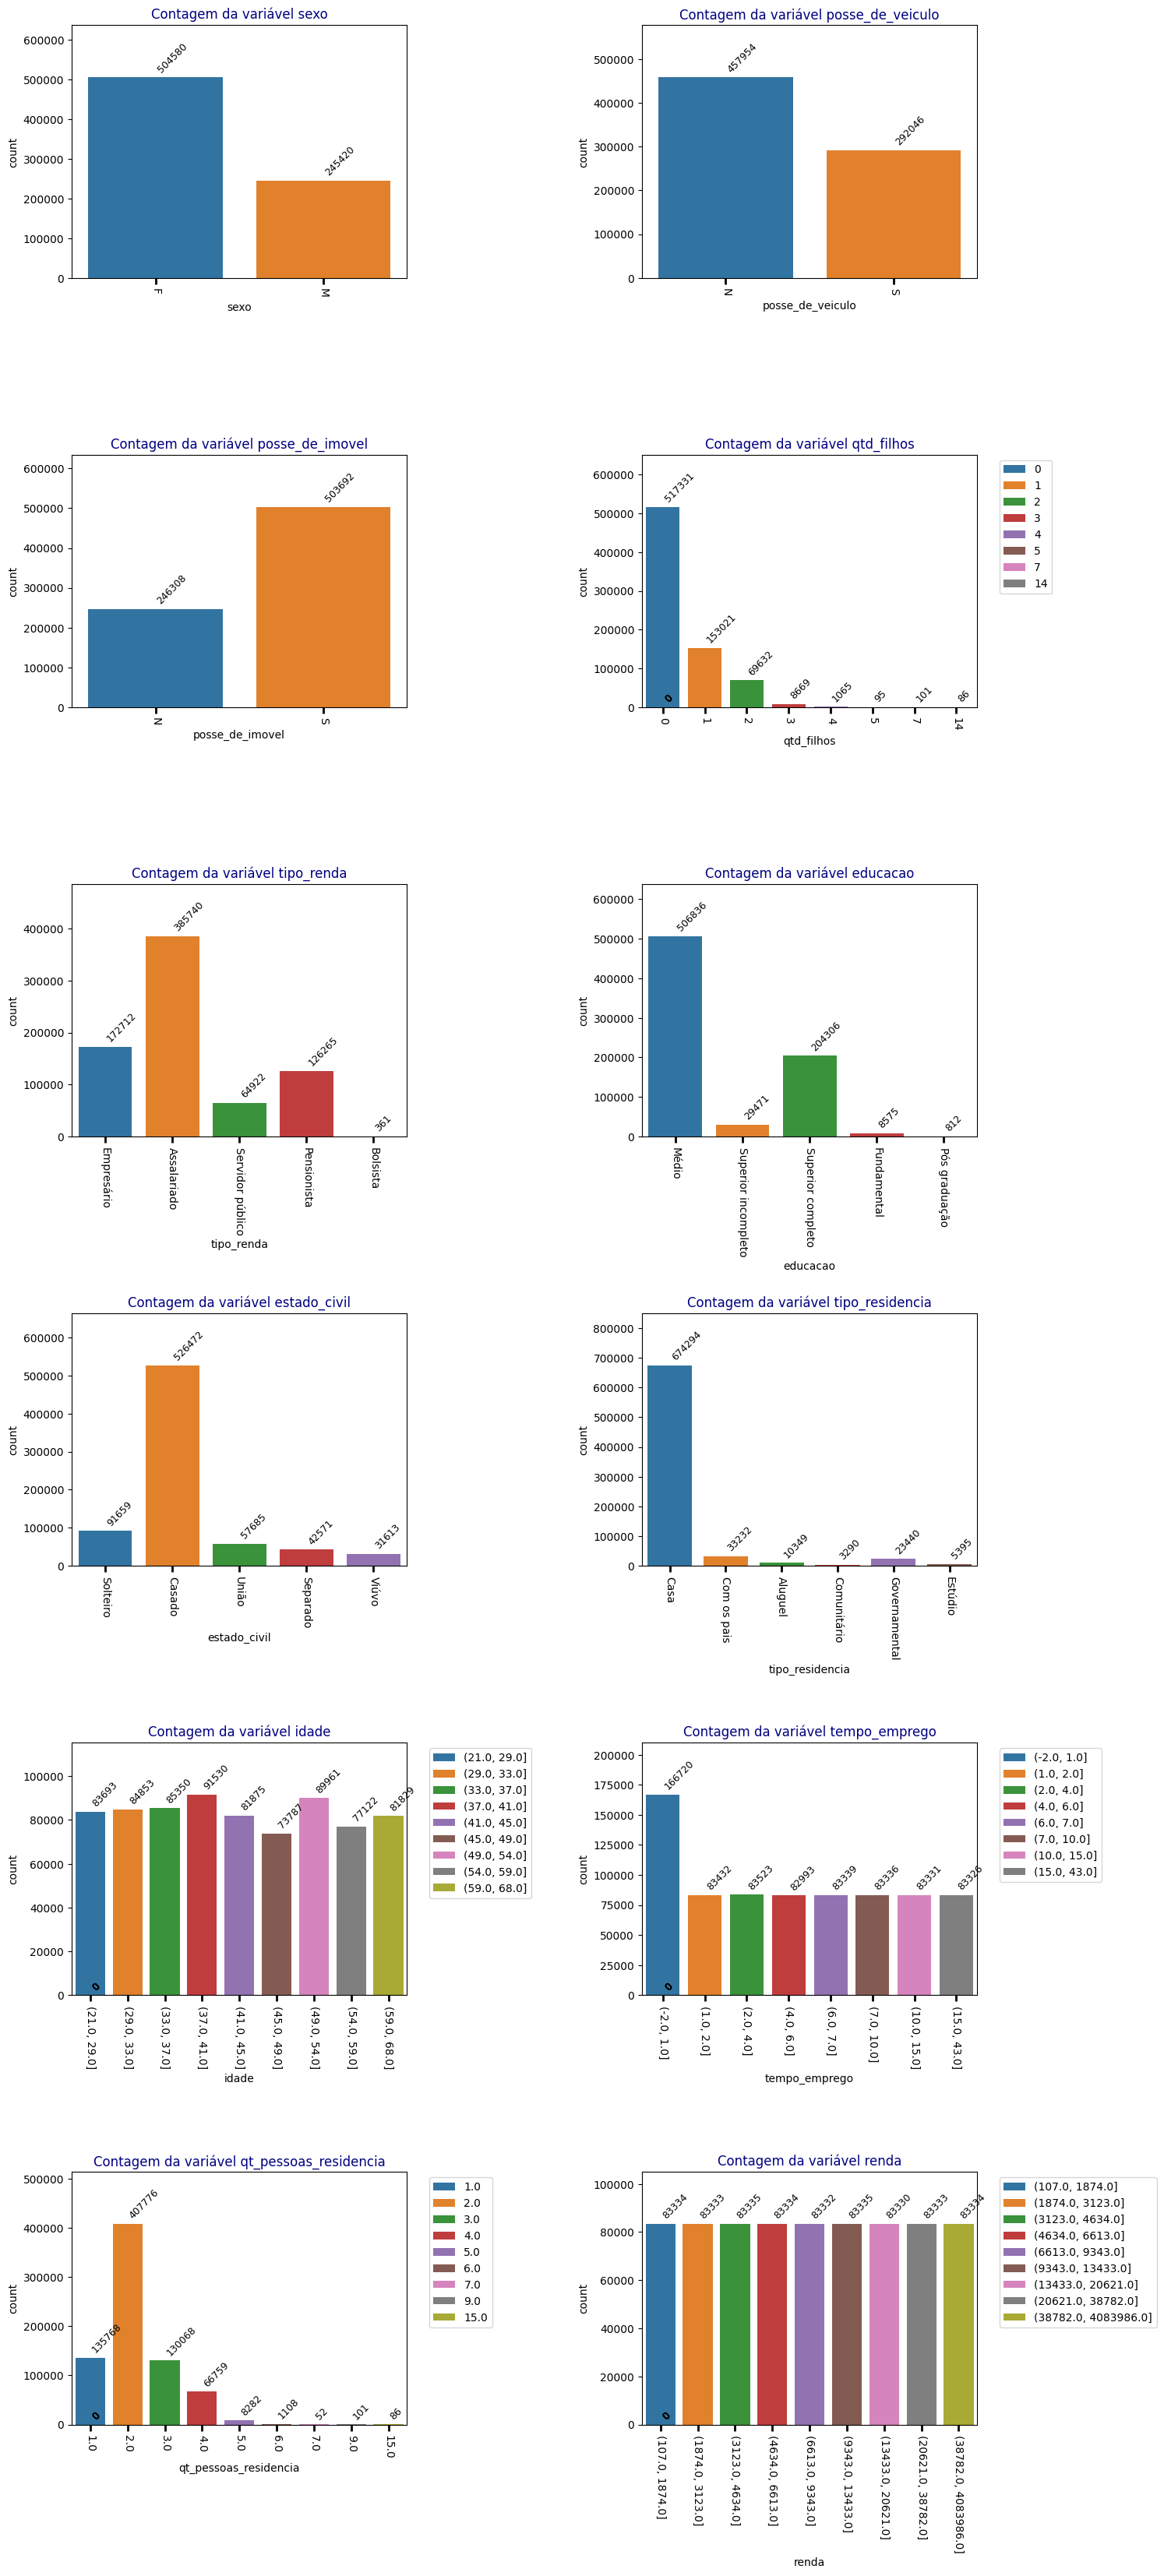

In [11]:
# Gerando gráfico de contagem de cada variavel.

fig, axes = plt.subplots(6,2, figsize=(15,40))
plt.subplots_adjust(wspace=.7, hspace=.7)

ax1 = sns.countplot(ax=axes[0,0], data=df, x='sexo', hue='sexo', palette='tab10')

ax2 = sns.countplot(ax=axes[0,1], data=df, x='posse_de_veiculo', hue='posse_de_veiculo', palette='tab10')

ax3 = sns.countplot(ax=axes[1,0], data=df, x='posse_de_imovel', hue='posse_de_imovel', palette='tab10')

ax4 = sns.countplot(ax=axes[1,1], data=df, x='qtd_filhos', hue='qtd_filhos', palette='tab10')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax5 = sns.countplot(ax=axes[2,0], data=df, x='tipo_renda', hue='tipo_renda', palette='tab10')

ax6 = sns.countplot(ax=axes[2,1], data=df, x='educacao', hue='educacao', palette='tab10')

ax7 = sns.countplot(ax=axes[3,0], data=df, x='estado_civil', hue='estado_civil', palette='tab10')

ax8 = sns.countplot(ax=axes[3,1], data=df, x='tipo_residencia', hue='tipo_residencia', palette='tab10')

ax9 = sns.countplot(ax=axes[4,0], data=df_cut, x='idade', hue='idade', palette='tab10')
ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax10 = sns.countplot(ax=axes[4,1], data=df_cut, x='tempo_emprego', hue='tempo_emprego', palette='tab10')
ax10.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax11 = sns.countplot(ax=axes[5,0], data=df, x='qt_pessoas_residencia', hue='qt_pessoas_residencia', palette='tab10')
ax11.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax12 = sns.countplot(ax=axes[5,1], data=df_cut, x='renda', hue='renda', palette='tab10')
ax12.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    i.tick_params(axis='x', rotation=270, length=6, width=2, grid_color='r', grid_alpha=0.5)
    i.set_title(f'Contagem da variável {i.get_xlabel()}', color='navy')
    i.set_ylim(ymax=i.get_ylim()[1]*1.2)
    for p in i.patches:
        i.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='left', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                   textcoords='offset points', rotation=45)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(107.0, 1874.0]",60816,22518,0.270214,1217.057617,83334,0.001538,0.273229,0.267199,-0.993538,-0.978302,-1.008882,1.473650,1.488886,1.458307
"(1874.0, 3123.0]",71548,11785,0.141421,2485.064276,83333,0.001207,0.143786,0.139055,-1.803541,-1.784191,-1.823164,0.663647,0.682997,0.644024
"(3123.0, 4634.0]",75489,7846,0.094150,3849.155811,83335,0.001012,0.096133,0.092167,-2.263983,-2.240951,-2.287455,0.203205,0.226238,0.179734
"(4634.0, 6613.0]",77691,5643,0.067715,5572.696397,83334,0.000870,0.069421,0.066010,-2.622324,-2.595612,-2.649667,-0.155135,-0.128423,-0.182479
"(6613.0, 9343.0]",79196,4136,0.049633,7901.300486,83332,0.000752,0.051107,0.048158,-2.952197,-2.921366,-2.983908,-0.485009,-0.454178,-0.516720
"(9343.0, 13433.0]",80344,2991,0.035891,11255.685989,83335,0.000644,0.037154,0.034628,-3.290710,-3.254815,-3.327842,-0.823522,-0.787626,-0.860654
"(13433.0, 20621.0]",81290,2040,0.024481,16620.014268,83330,0.000535,0.025530,0.023432,-3.685073,-3.642030,-3.729954,-1.217885,-1.174841,-1.262766
"(20621.0, 38782.0]",82111,1222,0.014664,27868.547132,83333,0.000416,0.015480,0.013848,-4.207583,-4.152592,-4.265676,-1.740395,-1.685404,-1.798488
"(38782.0, 4083986.0]",82872,462,0.005544,132376.877955,83334,0.000257,0.006048,0.005040,-5.189488,-5.101946,-5.285332,-2.722300,-2.634758,-2.818144


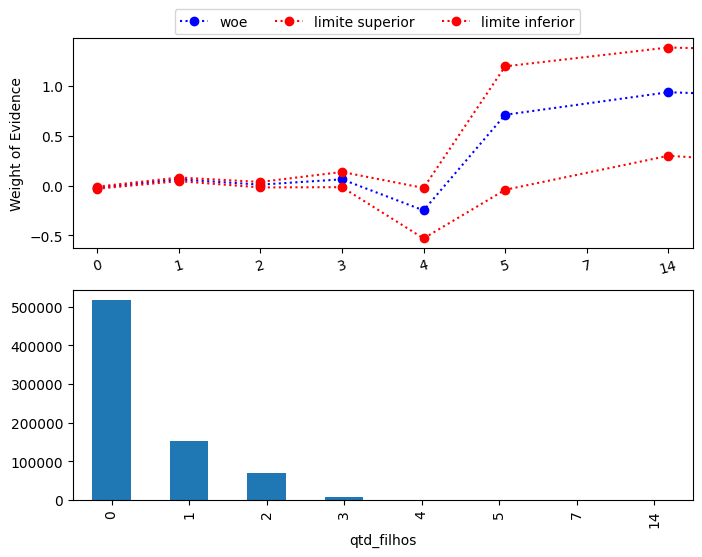

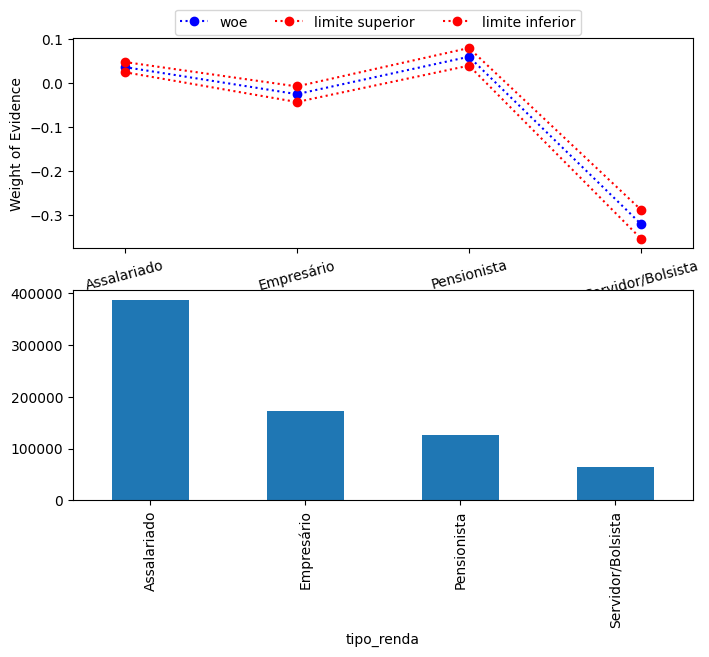

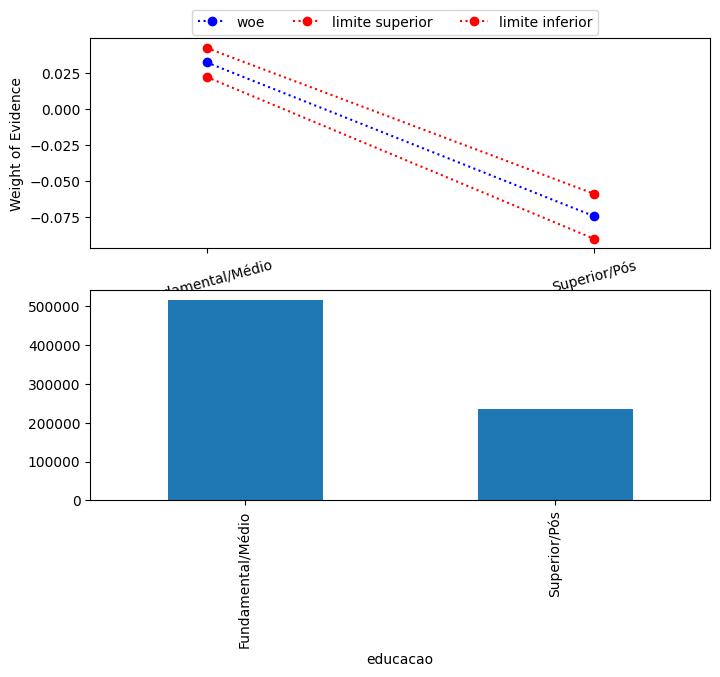

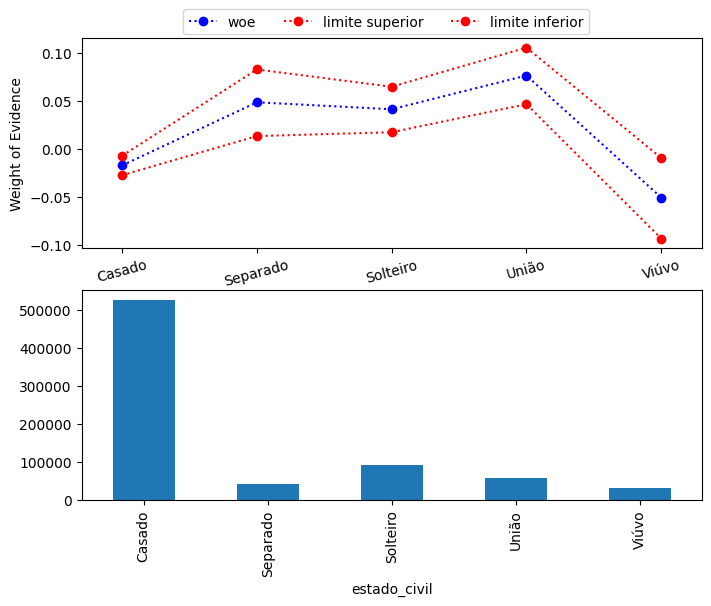

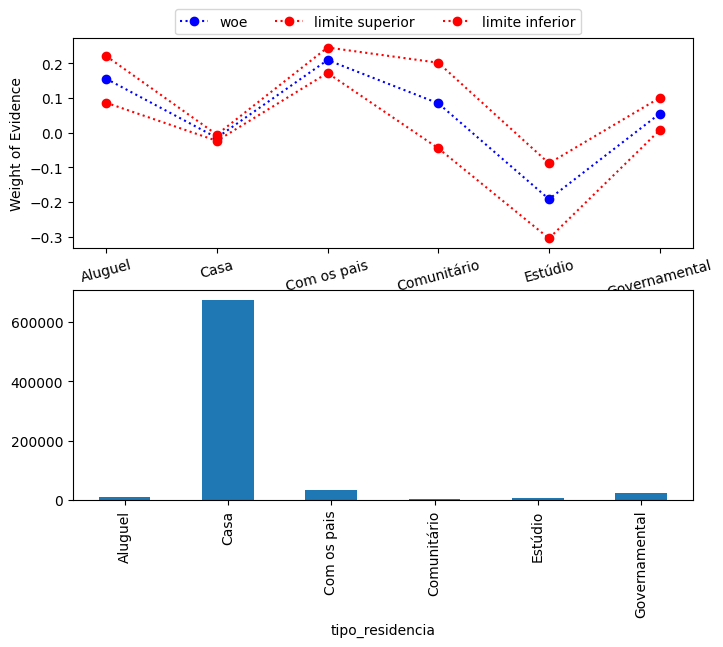

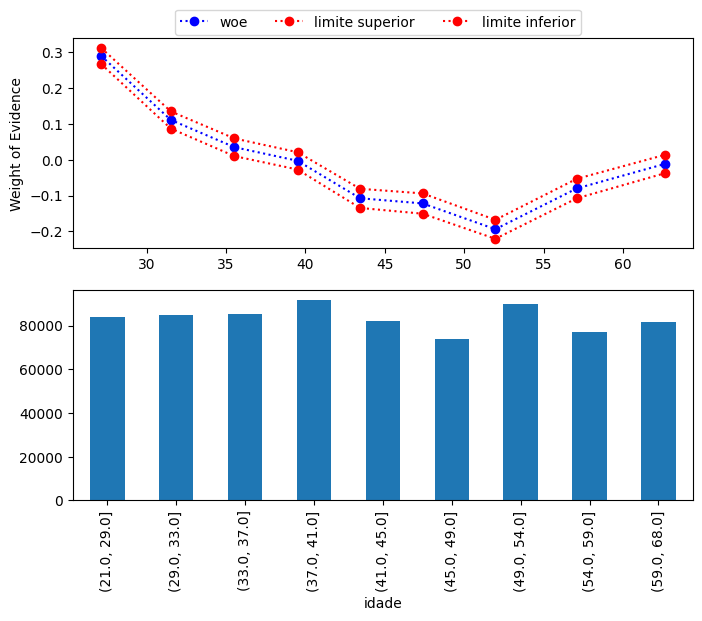

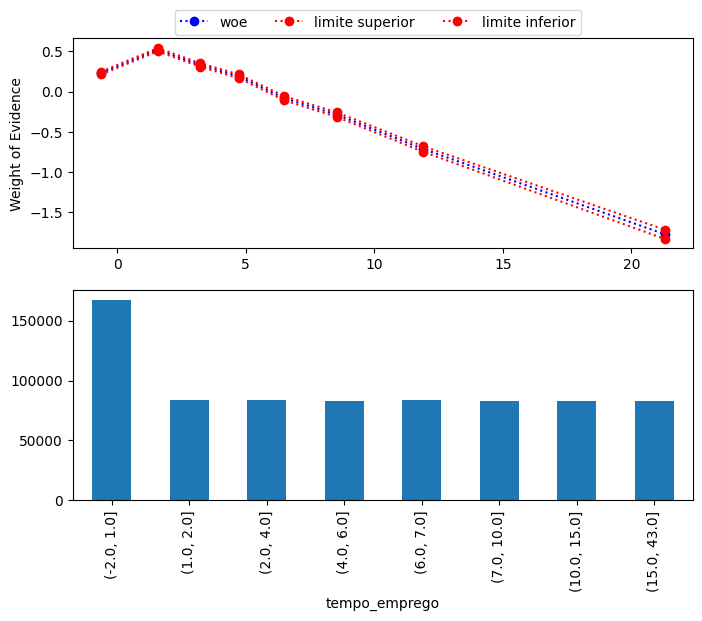

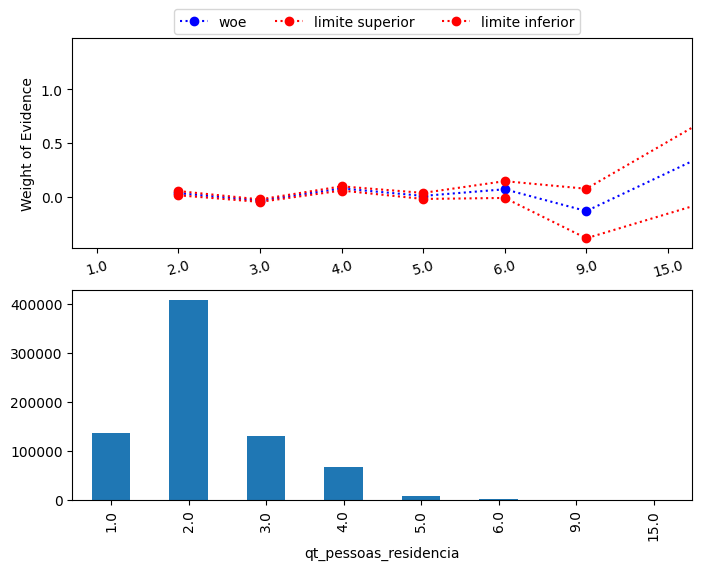

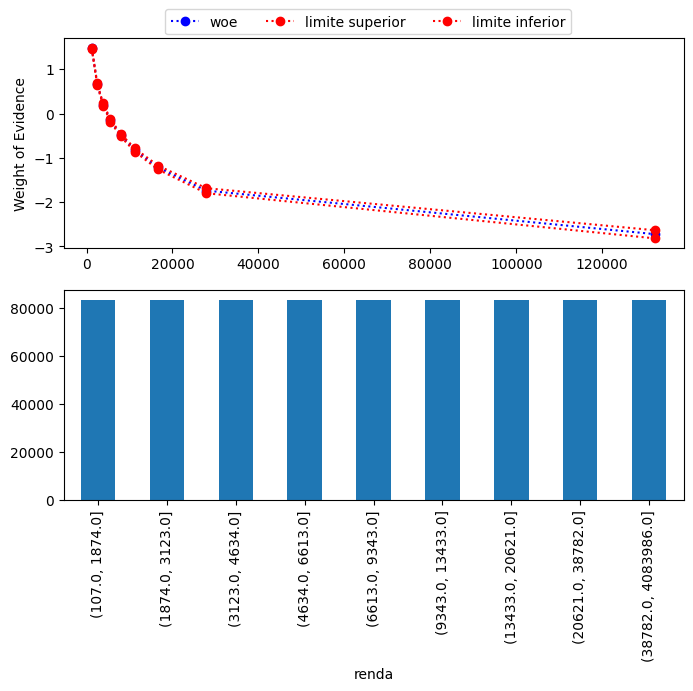

In [12]:
# Tratando os zeros estruturais.

df2 = df.copy()

df2.replace({'tipo_renda': {'Bolsista': 'Servidor/Bolsista', 'Servidor público': 'Servidor/Bolsista'}}, inplace=True)
df2.replace({'educacao': {'Fundamental':'Fundamental/Médio', 'Médio': 'Fundamental/Médio', 'Pós graduação': 'Superior/Pós', 'Superior completo': 'Superior/Pós', 'Superior incompleto': 'Superior/Pós'}}, inplace=True)
df2.replace({'qt_pessoas_residencia': {7: 6}}, inplace=True)


biv_discreta('qtd_filhos',df2)
biv_discreta('tipo_renda',df2)
biv_discreta('educacao',df2)
biv_discreta('estado_civil',df2)
biv_discreta('tipo_residencia',df2)
biv_continua('idade', 9, df2)
biv_continua('tempo_emprego', 9, df2)
biv_discreta('qt_pessoas_residencia',df2)
biv_continua('renda', 9, df2)

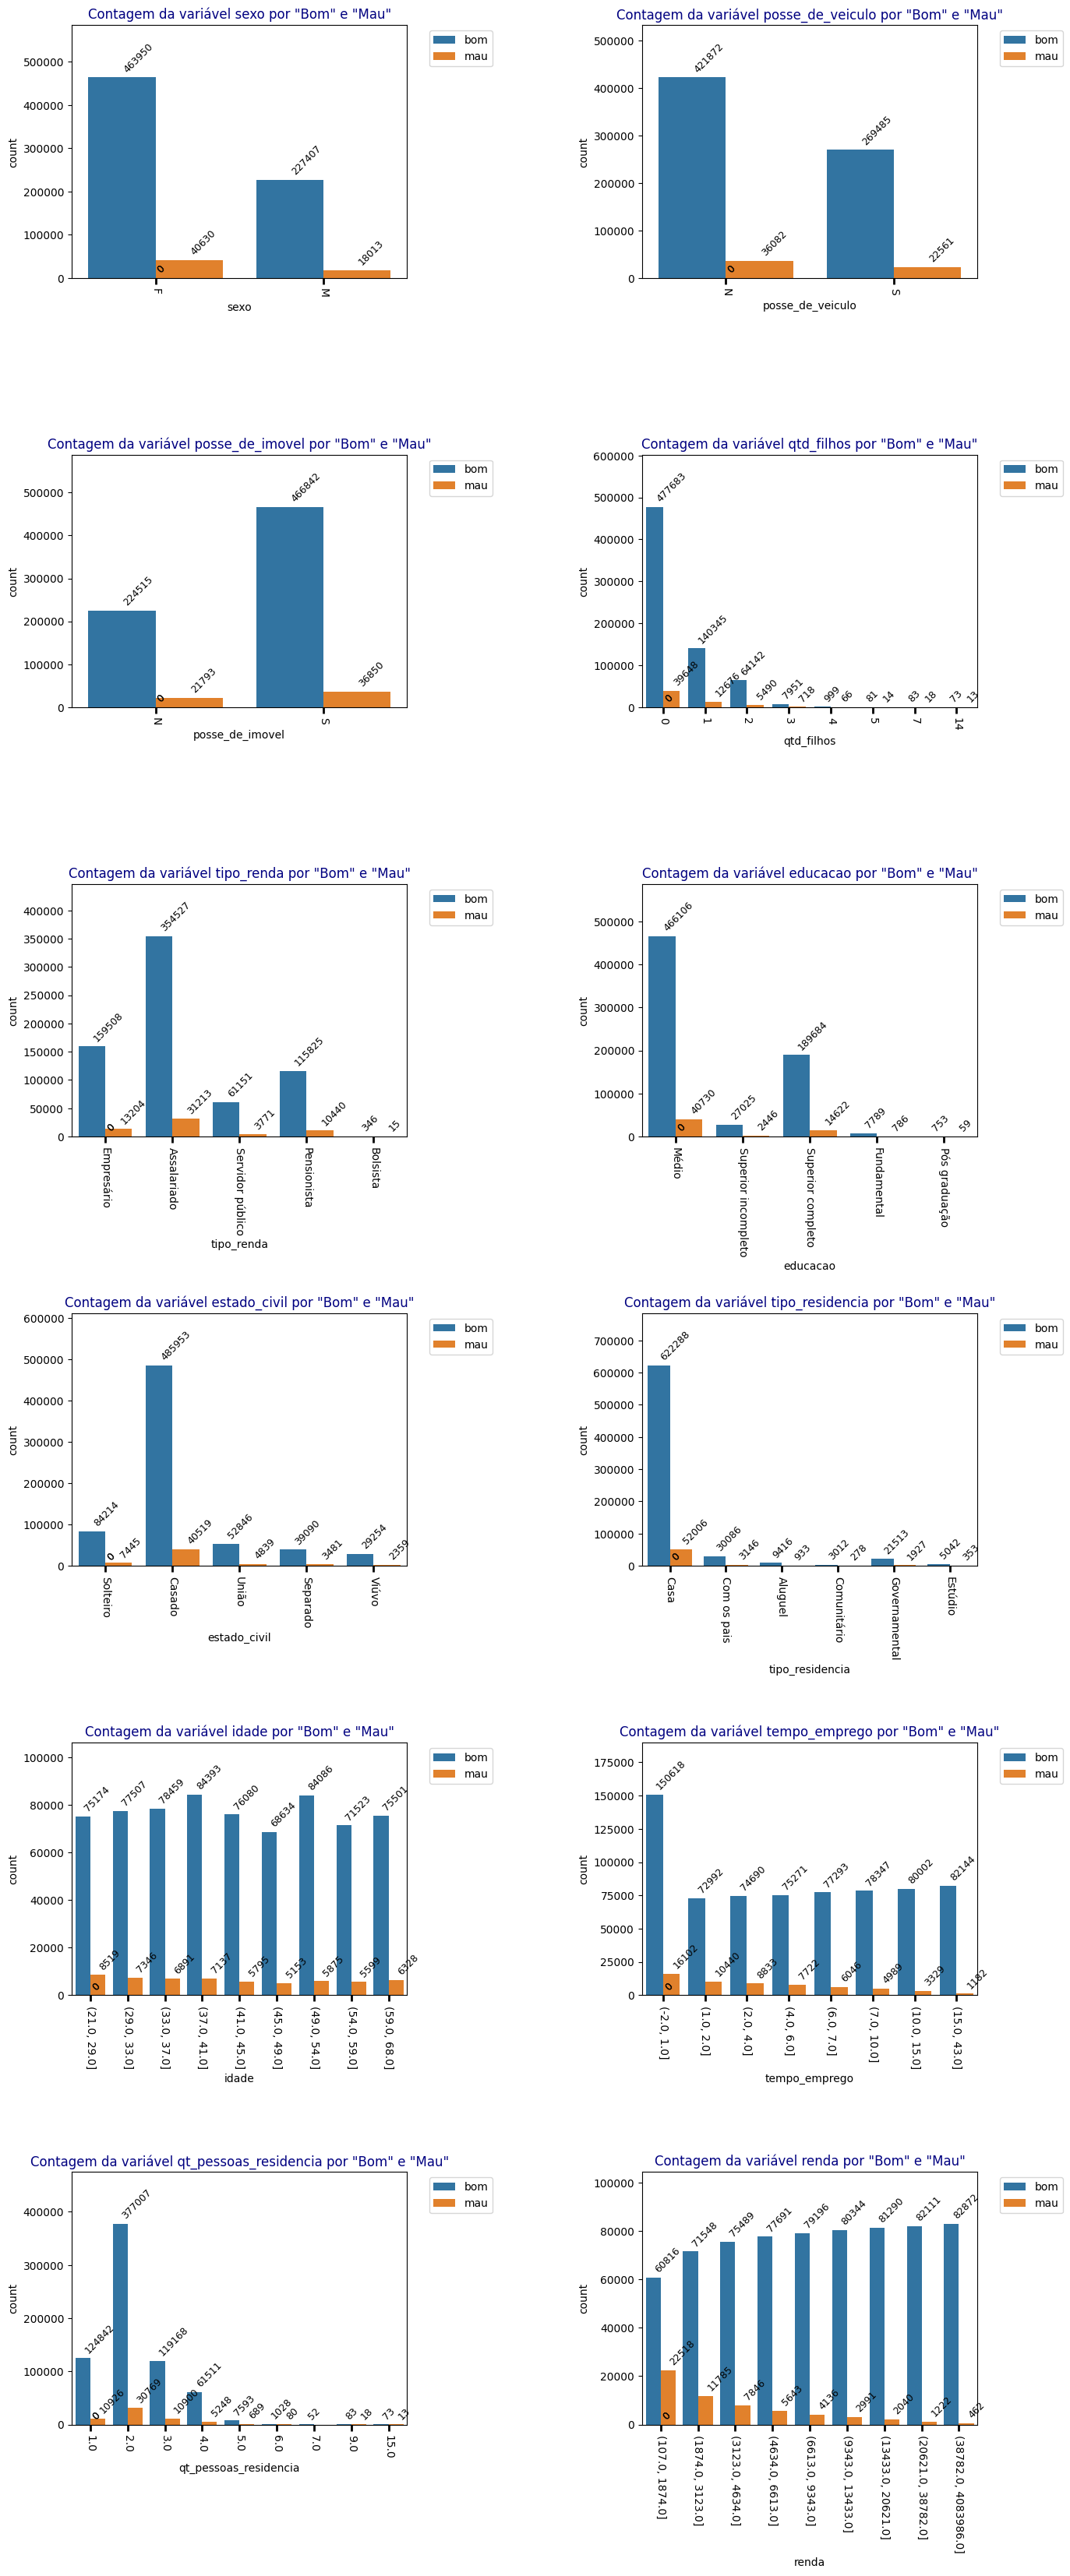

In [13]:
# Gerando gráfico de todas as variaveis por 'bom' e 'mau'.

fig, axes = plt.subplots(6,2, figsize=(15,40))
plt.subplots_adjust(wspace=.7, hspace=.7)

ax1 = sns.countplot(ax=axes[0,0], data=df, x='sexo', hue='mau')
ax2 = sns.countplot(ax=axes[0,1], data=df, x='posse_de_veiculo', hue='mau')
ax3 = sns.countplot(ax=axes[1,0], data=df, x='posse_de_imovel', hue='mau')
ax4 = sns.countplot(ax=axes[1,1], data=df, x='qtd_filhos', hue='mau')
ax5 = sns.countplot(ax=axes[2,0], data=df, x='tipo_renda', hue='mau')
ax6 = sns.countplot(ax=axes[2,1], data=df, x='educacao', hue='mau')
ax7 = sns.countplot(ax=axes[3,0], data=df, x='estado_civil', hue='mau')
ax8 = sns.countplot(ax=axes[3,1], data=df, x='tipo_residencia', hue='mau')
ax9 = sns.countplot(ax=axes[4,0], data=df_cut, x='idade', hue='mau')
ax10 = sns.countplot(ax=axes[4,1], data=df_cut, x='tempo_emprego', hue='mau')
ax11 = sns.countplot(ax=axes[5,0], data=df, x='qt_pessoas_residencia', hue='mau')
ax12 = sns.countplot(ax=axes[5,1], data=df_cut, x='renda', hue='mau')


for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    i.tick_params(axis='x', rotation=270, length=6, width=2, grid_color='r', grid_alpha=0.5)
    i.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=['bom', 'mau'])
    i.set_title(f'Contagem da variável {i.get_xlabel()} por "Bom" e "Mau"', color='navy')
    i.set_ylim(ymax=i.get_ylim()[1]*1.2)
    for p in i.patches:
        i.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='left', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                   textcoords='offset points', rotation=45)

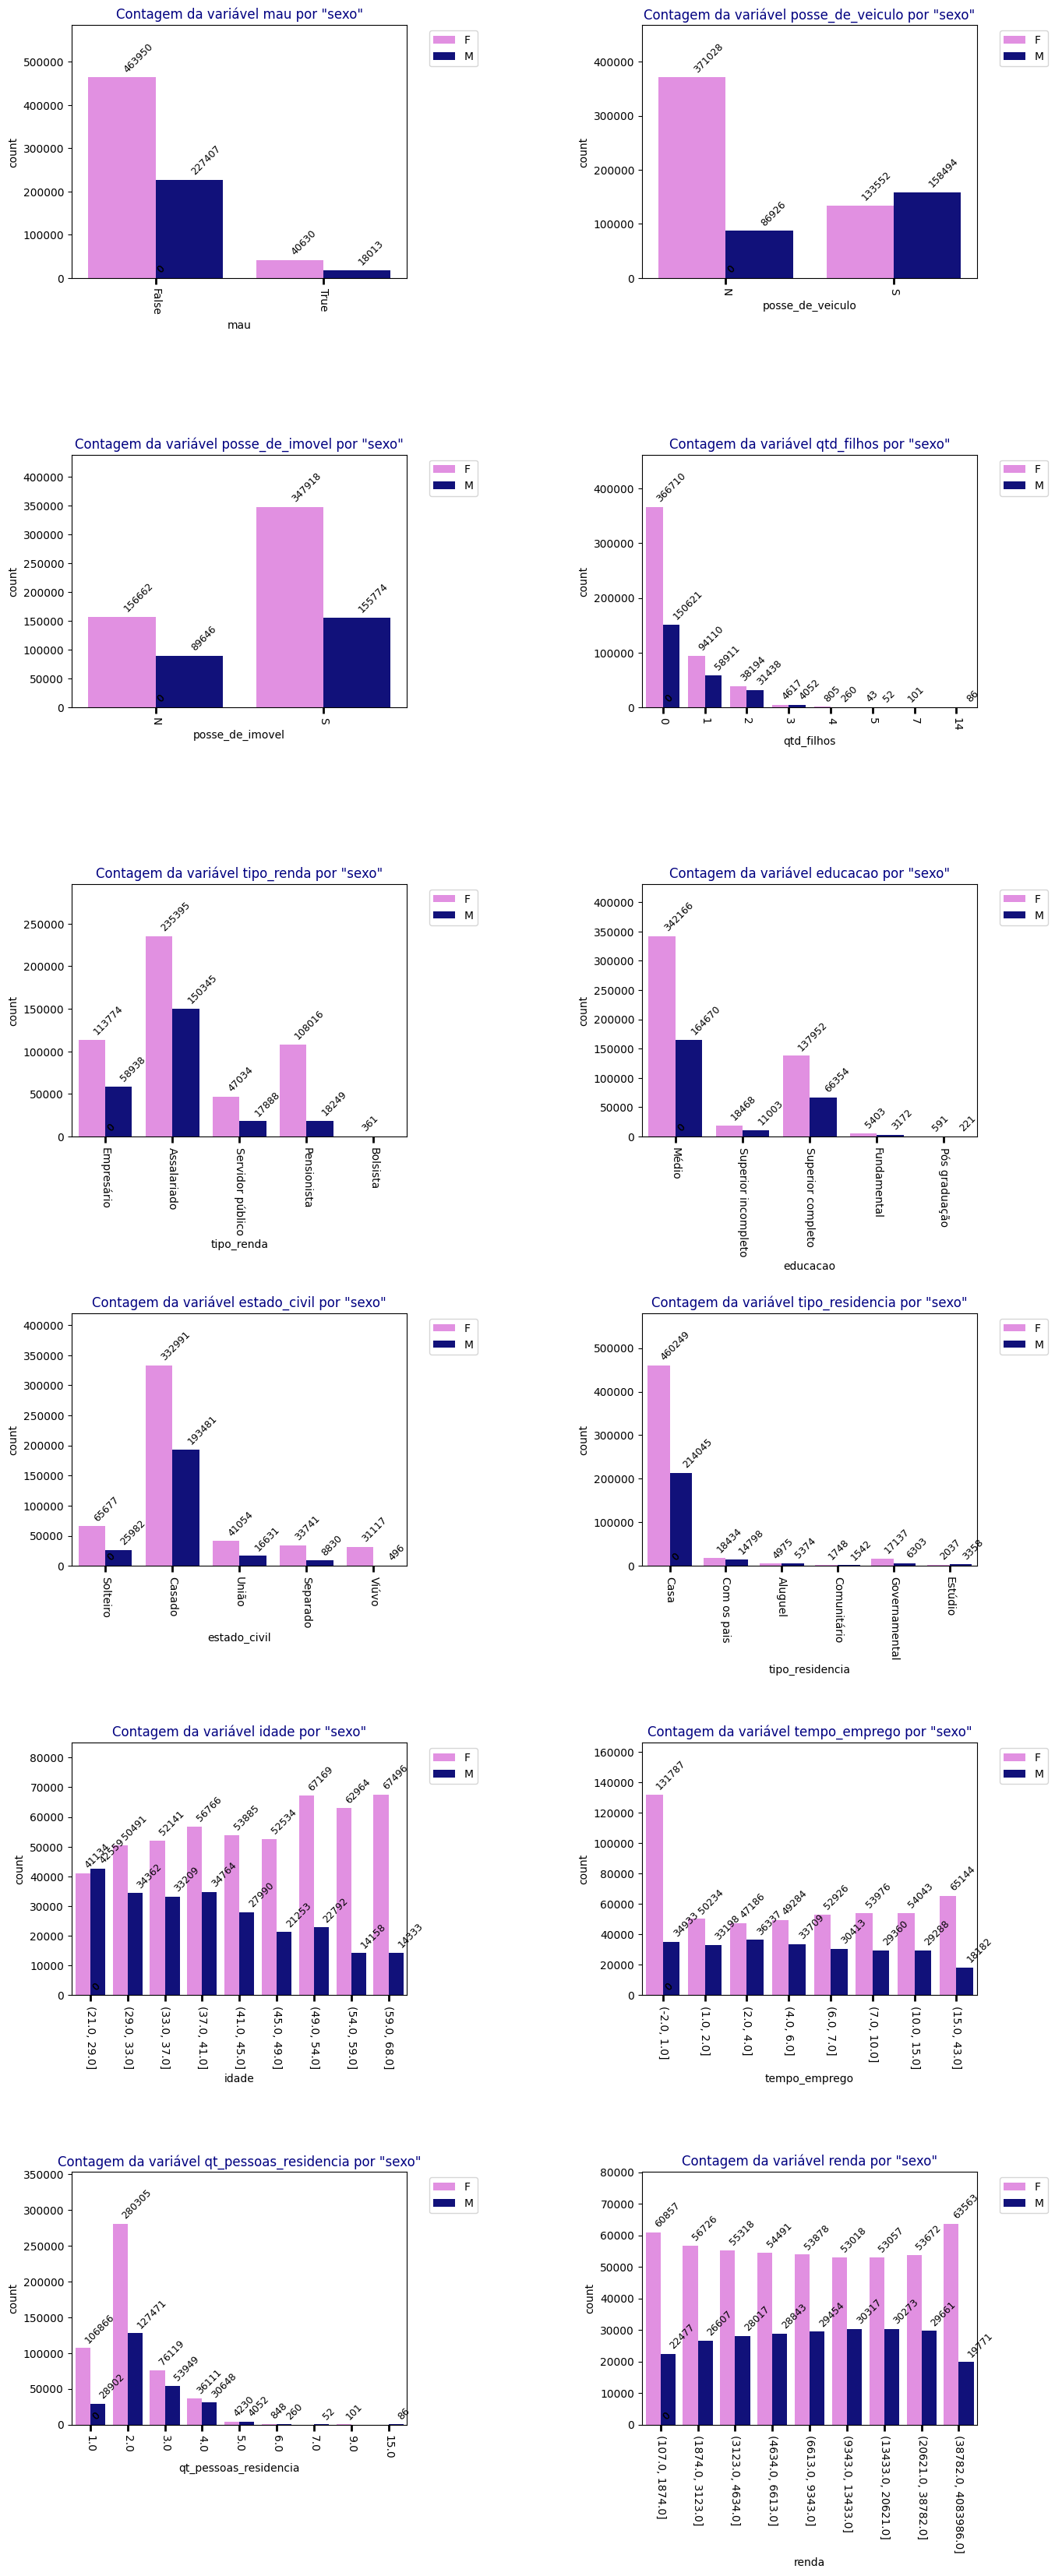

In [14]:
# Gerando gráfico de todas as variaveis por 'sexo'.

fig, axes = plt.subplots(6,2, figsize=(15,40))
plt.subplots_adjust(wspace=.7, hspace=.7)

ax1 = sns.countplot(ax=axes[0,0], data=df, x='mau', hue='sexo', palette=['violet', 'darkblue'])
ax2 = sns.countplot(ax=axes[0,1], data=df, x='posse_de_veiculo', hue='sexo', palette=['violet', 'darkblue'])
ax3 = sns.countplot(ax=axes[1,0], data=df, x='posse_de_imovel', hue='sexo', palette=['violet', 'darkblue'])
ax4 = sns.countplot(ax=axes[1,1], data=df, x='qtd_filhos', hue='sexo', palette=['violet', 'darkblue'])
ax5 = sns.countplot(ax=axes[2,0], data=df, x='tipo_renda', hue='sexo', palette=['violet', 'darkblue'])
ax6 = sns.countplot(ax=axes[2,1], data=df, x='educacao', hue='sexo', palette=['violet', 'darkblue'])
ax7 = sns.countplot(ax=axes[3,0], data=df, x='estado_civil', hue='sexo', palette=['violet', 'darkblue'])
ax8 = sns.countplot(ax=axes[3,1], data=df, x='tipo_residencia', hue='sexo', palette=['violet', 'darkblue'])
ax9 = sns.countplot(ax=axes[4,0], data=df_cut, x='idade', hue='sexo', palette=['violet', 'darkblue'])
ax10 = sns.countplot(ax=axes[4,1], data=df_cut, x='tempo_emprego', hue='sexo', palette=['violet', 'darkblue'])
ax11 = sns.countplot(ax=axes[5,0], data=df, x='qt_pessoas_residencia', hue='sexo', palette=['violet', 'darkblue'])
ax12 = sns.countplot(ax=axes[5,1], data=df_cut, x='renda', hue='sexo', palette=['violet', 'darkblue'])


for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    i.tick_params(axis='x', rotation=270, length=6, width=2, grid_color='r', grid_alpha=0.5)
    i.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    i.set_title(f'Contagem da variável {i.get_xlabel()} por "sexo"', color='navy')
    i.set_ylim(ymax=i.get_ylim()[1]*1.2)
    for p in i.patches:
        i.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='left', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                   textcoords='offset points', rotation=45)

In [51]:
# Para variáveis qualitativas, podemos usar uma tabela de contingência
qual_vars = df.select_dtypes(include=['object']).columns
for i in range(len(qual_vars)):
    for j in range(i+1, len(qual_vars)):
        contingency_table = pd.crosstab(df[qual_vars[i]], df[qual_vars[j]])
        print(f'Tabela entre {qual_vars[i]} e {qual_vars[j]}:')
        print(contingency_table)

Tabela entre sexo e posse_de_veiculo:
posse_de_veiculo       N       S
sexo                            
F                 371028  133552
M                  86926  158494
Tabela entre sexo e posse_de_imovel:
posse_de_imovel       N       S
sexo                           
F                156662  347918
M                 89646  155774
Tabela entre sexo e tipo_renda:
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                235395       361      113774       108016             47034
M                150345         0       58938        18249             17888
Tabela entre sexo e educacao:
educacao  Fundamental   Médio  Pós graduação  Superior completo  \
sexo                                                              
F                5403  342166            591             137952   
M                3172  164670            221              66354   

educacao  Superior incompl

## **Variáveis:**
- **'sexo':** 
    - A quantidade de mulheres é superior que a de homens.
    - A quantidade de homens que possuem veículos é superior que a de mulheres.
    - A quantidade de homens entre 21 a 29 anos é supeior que a de mulheres da mesma idade.

- **'posse_de_veiculo':**
    - A maioria das mulheres não possuem veículos.
    - Pessoas entre 29 a 33 anos possuem veículos.

- **'posse_de_imovel':**
    - A maioria das pessoas possuem imóveis.
    - A maioria das pessoas que moram "Com os pais" ou em residencia "Governamental" não possuem imóvel.

- **'qtd_filhos':**

- **'tipo_renda':**
    - Pessoas entre 54 a 68 anos são pensionistas.
    - A maioria das pessoas sem "tempo_emprego" são pensionistas.

- **'educacao':** 

- **'estado_civil':** 

- **'tipo_residencia':** 

- **'idade':** 

- **'tempo_emprego':** 

- **'qt_pessoas_residencia':** 

- **'renda':** 

- **'mau':** 

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [16]:
for var in analise_df[analise_df.papel!='resposta'].index:
    if  (analise_df.loc[var, 'nunique']>45):
        analise_df.loc[var, 'IV'] = IV(pd.qcut(df[var],15,duplicates='drop'), df.mau)
    else: 
        analise_df.loc[var, 'IV'] = IV(df[var], df.mau)
    
analise_df.sort_values(by='IV', ascending=False, inplace=True)
analise_df

,dtype,contagem,missing,nunique,papel,IV
qt_pessoas_residencia,float64,750000,0,9,covariavel,inf
renda,float64,750000,0,142419,covariavel,1.192576
tempo_emprego,float64,750000,0,3005,covariavel,0.312302
idade,int64,750000,0,47,covariavel,0.021826
posse_de_imovel,object,750000,0,2,covariavel,0.009693
tipo_renda,object,750000,0,5,covariavel,0.009360
educacao,object,750000,0,5,covariavel,0.003547
tipo_residencia,object,750000,0,6,covariavel,0.003045
sexo,object,750000,0,2,covariavel,0.002185
qtd_filhos,int64,750000,0,8,covariavel,0.001631


In [17]:
print(f'\033[1;7mInformation Value (IV):\033[0m\n{"-"*36}')

for i, j in zip(analise_df.index, analise_df.IV):
    if j > 0.5:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Suspeito de tão alto)\033[0m\n{"-"*36}')
    elif j > 0.3:
        print(f'\033[1m{i}:\033[0m\033[1;94m {j:.3f} (Forte)\033[0m\n{"-"*36}')
    elif j > 0.1:
        print(f'\033[1m{i}:\033[0m\033[1;92m {j:.3f} (Médio)\033[0m\n{"-"*36}')
    elif j > 0.02:
        print(f'\033[1m{i}:\033[0m\033[1;93m {j:.3f} (Fraco)\033[0m\n{"-"*36}')
    else:
        print(f'\033[1m{i}:\033[0m\033[1;91m {j:.3f} (Inútil)\033[0m\n{"-"*36}')

Information Value (IV):
------------------------------------
qt_pessoas_residencia: inf (Suspeito de tão alto)
------------------------------------
renda: 1.193 (Suspeito de tão alto)
------------------------------------
tempo_emprego: 0.312 (Forte)
------------------------------------
idade: 0.022 (Fraco)
------------------------------------
posse_de_imovel: 0.010 (Inútil)
------------------------------------
tipo_renda: 0.009 (Inútil)
------------------------------------
educacao: 0.004 (Inútil)
------------------------------------
tipo_residencia: 0.003 (Inútil)
------------------------------------
sexo: 0.002 (Inútil)
------------------------------------
qtd_filhos: 0.002 (Inútil)
------------------------------------
estado_civil: 0.001 (Inútil)
------------------------------------
posse_de_veiculo: 0.000 (Inútil)
------------------------------------
mau: nan (Inútil)
------------------------------------


In [18]:
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.